In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('Historical Series Case Study LUISS.xlsx',sheet_name='IBM',engine='openpyxl',skiprows=range(1))
df = df.iloc[:,:2]
df.columns=['IBM DAILY DATA','Price close']

In [3]:
df.index = pd.to_datetime(df['IBM DAILY DATA'],format='%Y-%m-%d')
df.drop(['IBM DAILY DATA'],axis=1,inplace=True)

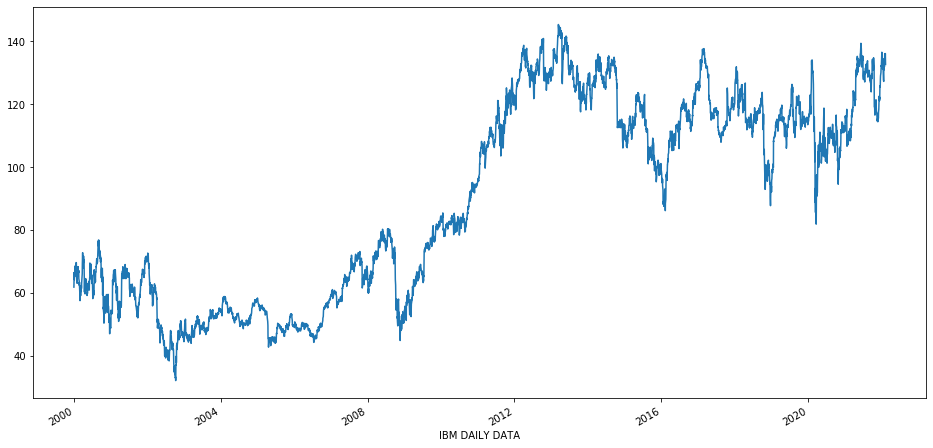

In [4]:
df['Price close'].plot(figsize=(16,8))

In [5]:
df

,Price close
IBM DAILY DATA,
1999-12-31,61.780476
2000-01-03,66.433693
2000-01-04,64.178642
2000-01-05,66.433693
2000-01-06,65.288307
...,...
2022-02-07,135.606552
2022-02-08,135.389175
2022-02-09,136.149994


In [6]:
q_70 = int(len(df.index) * .7)
df_train = df[:q_70]
df_test = df[q_70:]

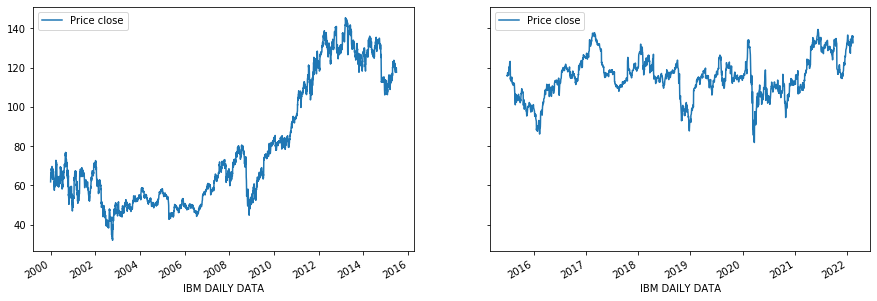

In [7]:
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1),sharey=ax1)
df_train.plot(ax=ax1)
df_test.plot(ax=ax2)
plt.savefig('train test.png')

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df_train)
df_scaled = scaler.transform(df_train)
df_scaled.shape

(3896, 1)

In [9]:
def df_to_X_y(df,windowsize):
    X=[]
    y=[]
    for i in range(len(df_scaled)-windowsize):
        row = [[a] for a in df_scaled[i:i+windowsize]]
        X.append(row)
        label = df_scaled[i+windowsize]
        y.append(label)
        
    return np.array(X), np.array(y)

In [10]:
Close = df_train['Price close']
WINDOWSIZE = 5
X_5,y_5 = df_to_X_y(Close, WINDOWSIZE)
Close.shape, X_5.shape, y_5.shape

((3896,), (3891, 5, 1, 1), (3891, 1))

In [11]:
X_5 = np.reshape(X_5,(X_5.shape[0], X_5.shape[1], X_5.shape[2]))
y_5 = np.reshape(y_5,(y_5.shape[0],))

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_5.shape[1],1)))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mse', 
              optimizer='adam',
              metrics=['mean_absolute_error'])

In [13]:
model.fit(X_5, y_5, epochs=20, batch_size=64)

Train on 3891 samples
Epoch 1/20
3891/3891 [==============================] - 5s 1ms/sample - loss: 0.0438 - mean_absolute_error: 0.1276
Epoch 2/20
3891/3891 [==============================] - 2s 424us/sample - loss: 4.7997e-04 - mean_absolute_error: 0.0166
Epoch 3/20
3891/3891 [==============================] - 2s 416us/sample - loss: 3.8881e-04 - mean_absolute_error: 0.0148
Epoch 4/20
3891/3891 [==============================] - 2s 420us/sample - loss: 3.5028e-04 - mean_absolute_error: 0.0138
Epoch 5/20
3891/3891 [==============================] - 2s 429us/sample - loss: 3.2919e-04 - mean_absolute_error: 0.0131
Epoch 6/20
3891/3891 [==============================] - 2s 419us/sample - loss: 3.1499e-04 - mean_absolute_error: 0.0127
Epoch 7/20
3891/3891 [==============================] - 2s 418us/sample - loss: 3.0876e-04 - mean_absolute_error: 0.0125
Epoch 8/20
3891/3891 [==============================] - 2s 420us/sample - loss: 3.0904e-04 - mean_absolute_error: 0.0125
Epoch 9/20
3891/

In [14]:
dataset_total = pd.concat((df_train,df_test), axis=0)

In [15]:
dataset_total

,Price close
IBM DAILY DATA,
1999-12-31,61.780476
2000-01-03,66.433693
2000-01-04,64.178642
2000-01-05,66.433693
2000-01-06,65.288307
...,...
2022-02-07,135.606552
2022-02-08,135.389175
2022-02-09,136.149994


In [16]:
inputs = dataset_total[len(dataset_total)-len(df_test)-WINDOWSIZE:].values

In [17]:
inputs

array([[119.23110199],
       [119.86377716],
       [118.69086456],
       ...,
       [136.1499939 ],
       [133.52000427],
       [132.69000244]])

In [18]:
len(inputs) ## utilizza i primi 5 per predire il primo giorno di test

1675

In [19]:
inputs = inputs.reshape(-1,1)

In [20]:
inputs = scaler.transform(inputs)

In [21]:
X_test = []
for i in range(WINDOWSIZE,len(inputs)):
    X_test.append(inputs[i-WINDOWSIZE:i, 0])

In [22]:
X_test = np.array(X_test)

In [23]:
X_test.shape

(1670, 5)

In [24]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(1670, 5, 1)

In [25]:
test_predictions5 = model.predict(X_test)
test_predictions5 = scaler.inverse_transform(test_predictions5)

/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


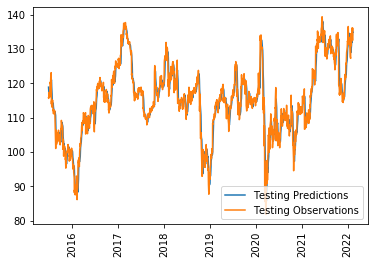

In [26]:
plt.plot(df_test.index, test_predictions5)
plt.plot(df_test.index, df_test.values)
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [27]:
test_predictions5.shape

(1670, 1)

In [28]:
te = df_test.values

In [29]:
df_test.index.shape

(1670,)

In [30]:
test_predictions5 = np.reshape(test_predictions5,(1670,))

In [31]:
te = np.reshape(te,(1670,))

In [32]:
test_results5 = pd.DataFrame(data={'Test Predictions':test_predictions5, 'Actuals':te},index=df_test.index)
test_results5

,Test Predictions,Actuals
IBM DAILY DATA,,
2015-06-29,118.901062,115.847435
2015-06-30,118.376312,115.627098
2015-07-01,117.509064,116.927971
2015-07-02,116.933449,117.354454
2015-07-06,116.606323,117.098587
...,...,...
2022-02-07,133.907684,135.606552
2022-02-08,134.783890,135.389175
2022-02-09,135.163849,136.149994


In [33]:
rmse5=np.sqrt(np.mean(((test_results5['Test Predictions']- test_results5['Actuals'])**2)))
rmse5

2.748397841528289

In [34]:
mae5 = np.mean(np.abs(test_results5['Test Predictions']-test_results5['Actuals']))
mae5

1.917061432250245

In [35]:
MAPE5 = np.mean(np.abs(((test_results5['Test Predictions']-test_results5['Actuals'])/test_results5['Actuals'])*100))
MAPE5

1.7047816287161308

In [36]:
from sklearn.metrics import r2_score
r2_5 = r2_score(test_results5['Actuals'], test_results5['Test Predictions'])
r2_5

0.9295494043712624

In [37]:
Close = df_train['Price close']
WINDOWSIZE = 10
X_10,y_10 = df_to_X_y(Close, WINDOWSIZE)
Close.shape, X_10.shape, y_10.shape

((3896,), (3886, 10, 1, 1), (3886, 1))

In [38]:
X_10 = np.reshape(X_10,(X_10.shape[0], X_10.shape[1], X_10.shape[2]))
y_10 = np.reshape(y_10,(y_10.shape[0],))

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_10.shape[1],1)))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mse', 
              optimizer='adam',
              metrics=['mean_absolute_error'])

In [40]:
model.fit(X_10, y_10, epochs=20, batch_size=64)

Train on 3886 samples
Epoch 1/20
3886/3886 [==============================] - 6s 2ms/sample - loss: 0.0186 - mean_absolute_error: 0.0784
Epoch 2/20
3886/3886 [==============================] - 3s 761us/sample - loss: 4.6177e-04 - mean_absolute_error: 0.0156
Epoch 3/20
3886/3886 [==============================] - 3s 767us/sample - loss: 4.4315e-04 - mean_absolute_error: 0.0152
Epoch 4/20
3886/3886 [==============================] - 3s 764us/sample - loss: 4.5115e-04 - mean_absolute_error: 0.0153
Epoch 5/20
3886/3886 [==============================] - 3s 773us/sample - loss: 4.3300e-04 - mean_absolute_error: 0.0150
Epoch 6/20
3886/3886 [==============================] - 3s 809us/sample - loss: 4.3505e-04 - mean_absolute_error: 0.0150
Epoch 7/20
3886/3886 [==============================] - 3s 771us/sample - loss: 4.3449e-04 - mean_absolute_error: 0.0151
Epoch 8/20
3886/3886 [==============================] - 3s 767us/sample - loss: 4.2354e-04 - mean_absolute_error: 0.0148
Epoch 9/20
3886/

In [41]:
inputs = dataset_total[len(dataset_total)-len(df_test)-WINDOWSIZE:].values
inputs

array([[118.18618011],
       [118.59846497],
       [118.8330307 ],
       ...,
       [136.1499939 ],
       [133.52000427],
       [132.69000244]])

In [42]:
len(inputs)

1680

In [43]:
inputs = inputs.reshape(-1,1)

In [44]:
inputs = scaler.transform(inputs)

In [45]:
X_test = []
for i in range(WINDOWSIZE,len(inputs)):
    X_test.append(inputs[i-WINDOWSIZE:i, 0])

In [46]:
X_test = np.array(X_test)
X_test.shape

(1670, 10)

In [47]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(1670, 10, 1)

In [48]:
test_predictions10 = model.predict(X_test)
test_predictions10 = scaler.inverse_transform(test_predictions10)

/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


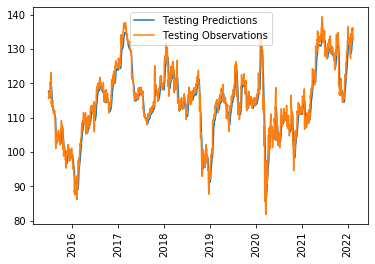

In [49]:
plt.plot(df_test.index, test_predictions10)
plt.plot(df_test.index, df_test.values)
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [50]:
test_predictions10 = np.reshape(test_predictions10,(1670,))

In [51]:
te = df_test.values 

In [52]:
te = np.reshape(te,(1670,))

In [53]:
test_results10 = pd.DataFrame(data={'Test Predictions':test_predictions10, 'Actuals':te},index=df_test.index)
test_results10

,Test Predictions,Actuals
IBM DAILY DATA,,
2015-06-29,117.719223,115.847435
2015-06-30,117.356148,115.627098
2015-07-01,116.884125,116.927971
2015-07-02,116.514801,117.354454
2015-07-06,116.260132,117.098587
...,...,...
2022-02-07,132.005447,135.606552
2022-02-08,132.552246,135.389175
2022-02-09,132.855438,136.149994


In [54]:
rmse10=np.sqrt(np.mean(((test_results10['Test Predictions']- test_results10['Actuals'])**2)))
mae10 = np.mean(np.abs(test_results10['Test Predictions']-test_results10['Actuals']))
MAPE10 = np.mean(np.abs(((test_results10['Test Predictions']-test_results10['Actuals'])/test_results10['Actuals'])*100))
r2_10 = r2_score(test_results10['Actuals'], test_results10['Test Predictions'])

rmse10, mae10, MAPE10, r2_10

(3.1971123299043414, 2.398240090558629, 2.1067501261236186, 0.9046674384687027)

In [55]:
Close = df_train['Price close']
WINDOWSIZE = 20
X_20,y_20 = df_to_X_y(Close, WINDOWSIZE)
df_scaled.shape, X_20.shape, y_20.shape

((3896, 1), (3876, 20, 1, 1), (3876, 1))

In [56]:
X_20 = np.reshape(X_20,(X_20.shape[0], X_20.shape[1], X_20.shape[2]))
y_20 = np.reshape(y_20,(y_20.shape[0],))

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_20.shape[1],1)))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mse', 
              optimizer='adam',
              metrics=['mean_absolute_error'])

In [58]:
model.fit(X_20, y_20, epochs=20, batch_size=64)

Train on 3876 samples
Epoch 1/20
3876/3876 [==============================] - 9s 2ms/sample - loss: 0.0099 - mean_absolute_error: 0.0585
Epoch 2/20
3876/3876 [==============================] - 6s 1ms/sample - loss: 5.7947e-04 - mean_absolute_error: 0.0175
Epoch 3/20
3876/3876 [==============================] - 6s 1ms/sample - loss: 5.6919e-04 - mean_absolute_error: 0.0175
Epoch 4/20
3876/3876 [==============================] - 6s 1ms/sample - loss: 5.5107e-04 - mean_absolute_error: 0.0171
Epoch 5/20
3876/3876 [==============================] - 6s 1ms/sample - loss: 5.3936e-04 - mean_absolute_error: 0.0169
Epoch 6/20
3876/3876 [==============================] - 6s 1ms/sample - loss: 5.2963e-04 - mean_absolute_error: 0.0168
Epoch 7/20
3876/3876 [==============================] - 6s 1ms/sample - loss: 5.2079e-04 - mean_absolute_error: 0.0166
Epoch 8/20
3876/3876 [==============================] - 6s 1ms/sample - loss: 4.8760e-04 - mean_absolute_error: 0.0160
Epoch 9/20
3876/3876 [========

In [59]:
inputs = dataset_total[len(dataset_total)-len(df_test)-WINDOWSIZE:].values
inputs

array([[120.97272491],
       [120.59598541],
       [120.78787994],
       ...,
       [136.1499939 ],
       [133.52000427],
       [132.69000244]])

In [60]:
len(inputs)

1690

In [61]:
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [62]:
X_test = []
for i in range(WINDOWSIZE,len(inputs)):
    X_test.append(inputs[i-WINDOWSIZE:i, 0])

In [63]:
X_test = np.array(X_test)
X_test.shape

(1670, 20)

In [64]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(1670, 20, 1)

In [65]:
test_predictions20 = model.predict(X_test)
test_predictions20 = scaler.inverse_transform(test_predictions20)

/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


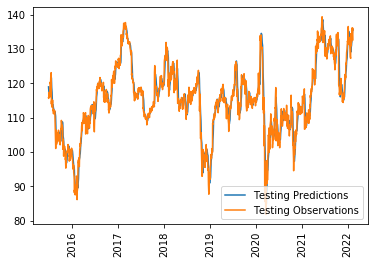

In [66]:
plt.plot(df_test.index, test_predictions20)
plt.plot(df_test.index, df_test.values)
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [67]:
test_predictions20 = np.reshape(test_predictions20,(1670,))
te = df_test.values 
te = np.reshape(te,(1670,))

In [68]:
test_results20 = pd.DataFrame(data={'Test Predictions':test_predictions20, 'Actuals':te},index=df_test.index)
test_results20

,Test Predictions,Actuals
IBM DAILY DATA,,
2015-06-29,118.989563,115.847435
2015-06-30,118.406860,115.627098
2015-07-01,117.720062,116.927971
2015-07-02,117.264000,117.354454
2015-07-06,117.044151,117.098587
...,...,...
2022-02-07,134.702515,135.606552
2022-02-08,135.257294,135.389175
2022-02-09,135.583405,136.149994


In [69]:
rmse20=np.sqrt(np.mean(((test_results20['Test Predictions']- test_results20['Actuals'])**2)))
mae20 = np.mean(np.abs(test_results20['Test Predictions']-test_results20['Actuals']))
MAPE20 = np.mean(np.abs(((test_results20['Test Predictions']-test_results20['Actuals'])/test_results20['Actuals'])*100))
r2_20 = r2_score(test_results20['Actuals'], test_results20['Test Predictions'])
rmse20, mae20, MAPE20, r2_20

(2.6236597675649893,
 1.8387920905016129,
 1.6393950401494126,
 0.9357991906605457)

In [70]:
Close = df_train['Price close']
WINDOWSIZE = 30
X_30,y_30 = df_to_X_y(Close, WINDOWSIZE)
Close.shape, X_30.shape, y_30.shape

((3896,), (3866, 30, 1, 1), (3866, 1))

In [71]:
X_30 = np.reshape(X_30,(X_30.shape[0], X_30.shape[1], X_30.shape[2]))
y_30 = np.reshape(y_30,(y_30.shape[0],))

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_30.shape[1],1)))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mse', 
              optimizer='adam',
              metrics=['mean_absolute_error'])

In [73]:
model.fit(X_30, y_30, epochs=20, batch_size=64)

Train on 3866 samples
Epoch 1/20
3866/3866 [==============================] - 11s 3ms/sample - loss: 0.0134 - mean_absolute_error: 0.0673
Epoch 2/20
3866/3866 [==============================] - 8s 2ms/sample - loss: 5.4365e-04 - mean_absolute_error: 0.0169
Epoch 3/20
3866/3866 [==============================] - 8s 2ms/sample - loss: 5.2028e-04 - mean_absolute_error: 0.0166
Epoch 4/20
3866/3866 [==============================] - 8s 2ms/sample - loss: 5.0606e-04 - mean_absolute_error: 0.0163
Epoch 5/20
3866/3866 [==============================] - 8s 2ms/sample - loss: 4.8642e-04 - mean_absolute_error: 0.0160
Epoch 6/20
3866/3866 [==============================] - 8s 2ms/sample - loss: 4.7205e-04 - mean_absolute_error: 0.0157
Epoch 7/20
3866/3866 [==============================] - 8s 2ms/sample - loss: 4.4946e-04 - mean_absolute_error: 0.0154
Epoch 8/20
3866/3866 [==============================] - 8s 2ms/sample - loss: 4.3868e-04 - mean_absolute_error: 0.0151
Epoch 9/20
3866/3866 [=======

In [74]:
inputs = dataset_total[len(dataset_total)-len(df_test)-WINDOWSIZE:].values
inputs

array([[123.16215515],
       [123.01998138],
       [123.31851959],
       ...,
       [136.1499939 ],
       [133.52000427],
       [132.69000244]])

In [75]:
len(inputs)

1700

In [76]:
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [77]:
X_test = []
for i in range(WINDOWSIZE,len(inputs)):
    X_test.append(inputs[i-WINDOWSIZE:i, 0])

In [78]:
X_test = np.array(X_test)
X_test.shape

(1670, 30)

In [79]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(1670, 30, 1)

In [80]:
test_predictions30 = model.predict(X_test)
test_predictions30 = scaler.inverse_transform(test_predictions30)

/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


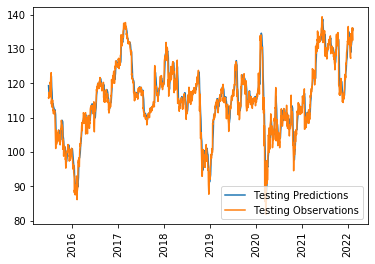

In [81]:
plt.plot(df_test.index, test_predictions30)
plt.plot(df_test.index, df_test.values)
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [82]:
test_predictions30 = np.reshape(test_predictions30,(1670,))
te = df_test.values 
te = np.reshape(te,(1670,))

In [83]:
test_results30 = pd.DataFrame(data={'Test Predictions':test_predictions30, 'Actuals':te},index=df_test.index)
test_results30

,Test Predictions,Actuals
IBM DAILY DATA,,
2015-06-29,119.345352,115.847435
2015-06-30,118.717697,115.627098
2015-07-01,117.983444,116.927971
2015-07-02,117.501266,117.354454
2015-07-06,117.288010,117.098587
...,...,...
2022-02-07,135.132828,135.606552
2022-02-08,135.628006,135.389175
2022-02-09,135.870560,136.149994


In [84]:
rmse30=np.sqrt(np.mean(((test_results30['Test Predictions']- test_results30['Actuals'])**2)))
mae30 = np.mean(np.abs(test_results30['Test Predictions']-test_results30['Actuals']))
MAPE30 = np.mean(np.abs(((test_results30['Test Predictions']-test_results30['Actuals'])/test_results30['Actuals'])*100))
r2_30 = r2_score(test_results30['Actuals'], test_results30['Test Predictions'])
rmse30, mae30, MAPE30, r2_30

(2.6141180609516246,
 1.8338394165039054,
 1.6395748914464752,
 0.9362653115896203)

In [85]:
Close = df_train['Price close']
WINDOWSIZE = 60
X_60,y_60 = df_to_X_y(Close, WINDOWSIZE)
Close.shape, X_60.shape, y_60.shape

((3896,), (3836, 60, 1, 1), (3836, 1))

In [86]:
X_60 = np.reshape(X_60,(X_60.shape[0], X_60.shape[1], X_60.shape[2]))
y_60 = np.reshape(y_60,(y_60.shape[0],))

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_60.shape[1],1)))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mse', 
              optimizer='adam',
              metrics=['mean_absolute_error'])

In [88]:
model.fit(X_60, y_60, epochs=20, batch_size=64)

Train on 3836 samples
Epoch 1/20
3836/3836 [==============================] - 19s 5ms/sample - loss: 0.0158 - mean_absolute_error: 0.0713
Epoch 2/20
3836/3836 [==============================] - 16s 4ms/sample - loss: 6.3790e-04 - mean_absolute_error: 0.0186
Epoch 3/20
3836/3836 [==============================] - 16s 4ms/sample - loss: 5.8474e-04 - mean_absolute_error: 0.0177
Epoch 4/20
3836/3836 [==============================] - 18s 5ms/sample - loss: 5.6436e-04 - mean_absolute_error: 0.0173
Epoch 5/20
3836/3836 [==============================] - 21s 5ms/sample - loss: 5.5442e-04 - mean_absolute_error: 0.0171
Epoch 6/20
3836/3836 [==============================] - 21s 5ms/sample - loss: 5.4026e-04 - mean_absolute_error: 0.0170
Epoch 7/20
3836/3836 [==============================] - 22s 6ms/sample - loss: 5.1850e-04 - mean_absolute_error: 0.0166
Epoch 8/20
3836/3836 [==============================] - 28s 7ms/sample - loss: 4.9496e-04 - mean_absolute_error: 0.0162
Epoch 9/20
3836/3836 [

In [89]:
inputs = dataset_total[len(dataset_total)-len(df_test)-WINDOWSIZE:].values
inputs

array([[113.19943237],
       [114.32122803],
       [114.3423996 ],
       ...,
       [136.1499939 ],
       [133.52000427],
       [132.69000244]])

In [90]:
len(inputs)

1730

In [91]:
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [92]:
X_test = []
for i in range(WINDOWSIZE,len(inputs)):
    X_test.append(inputs[i-WINDOWSIZE:i, 0])

In [93]:
X_test = np.array(X_test)
X_test.shape

(1670, 60)

In [94]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(1670, 60, 1)

In [95]:
test_predictions60 = model.predict(X_test)
test_predictions60 = scaler.inverse_transform(test_predictions60)

In [96]:
test_predictions60

array([[116.9978  ],
       [116.548676],
       [115.97796 ],
       ...,
       [132.75232 ],
       [133.10886 ],
       [133.03249 ]], dtype=float32)

/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


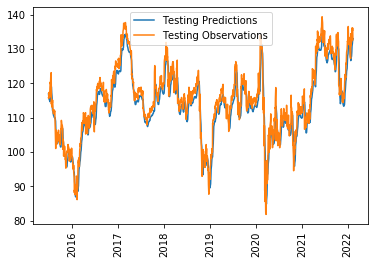

In [97]:
plt.plot(df_test.index, test_predictions60)
plt.plot(df_test.index, df_test.values)
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [98]:
test_predictions60 = np.reshape(test_predictions60,(1670,))
te = df_test.values 
te = np.reshape(te,(1670,))

In [99]:
test_results60 = pd.DataFrame(data={'Test Predictions':test_predictions60, 'Actuals':te},index=df_test.index)
test_results60

,Test Predictions,Actuals
IBM DAILY DATA,,
2015-06-29,116.997803,115.847435
2015-06-30,116.548676,115.627098
2015-07-01,115.977959,116.927971
2015-07-02,115.531769,117.354454
2015-07-06,115.234467,117.098587
...,...,...
2022-02-07,131.664398,135.606552
2022-02-08,132.307800,135.389175
2022-02-09,132.752319,136.149994


In [100]:
rmse60=np.sqrt(np.mean(((test_results60['Test Predictions']- test_results60['Actuals'])**2)))
mae60 = np.mean(np.abs(test_results60['Test Predictions']-test_results60['Actuals']))
MAPE60 = np.mean(np.abs(((test_results60['Test Predictions']-test_results60['Actuals'])/test_results60['Actuals'])*100))
r2_60 = r2_score(test_results60['Actuals'], test_results60['Test Predictions'])
rmse60, mae60, MAPE60, r2_60

(3.396902078639142, 2.7399998967519057, 2.3860271130326036, 0.8923803619149807)

In [101]:
index_bar = [5,10,20,30,60]

rmse = [rmse5,rmse10,rmse20,rmse30,rmse60]
mae = [mae5,mae10,mae20,mae30,mae60]
MAPE = [MAPE5,MAPE10,MAPE20,MAPE30,MAPE60]
r2 = [r2_5,r2_10,r2_20,r2_30,r2_60]

df_bar = pd.DataFrame(data={'rmse':rmse, 'mae':mae, 'MAPE':MAPE, 'r2':r2},index=index_bar)
df_bar

,rmse,mae,MAPE,r2
5,2.748398,1.917061,1.704782,0.929549
10,3.197112,2.398240,2.106750,0.904667
20,2.623660,1.838792,1.639395,0.935799
30,2.614118,1.833839,1.639575,0.936265
60,3.396902,2.740000,2.386027,0.892380


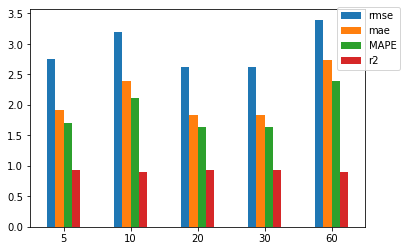

In [102]:
ax = df_bar.plot.bar(rot=0)
ax.legend(loc='best', bbox_to_anchor=(0.9, 0.7))
plt.savefig('Daily PERFORMANCE MATRICS BUONO.png')

In [ ]:
## SCELGO 20 GIORNI

In [10]:
Close = df_train['Price close']
WINDOWSIZE = 20
X_20,y_20 = df_to_X_y(Close, WINDOWSIZE)
Close.shape, X_20.shape, y_20.shape

((3896,), (3876, 20, 1, 1), (3876, 1))

In [11]:
X_20 = np.reshape(X_20,(X_20.shape[0], X_20.shape[1], X_20.shape[2]))
y_20 = np.reshape(y_20,(y_20.shape[0],))

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_20.shape[1],1)))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mse', 
              optimizer='adam',
              metrics=['mean_absolute_error'])

In [106]:
model.fit(X_20, y_20, epochs=30, batch_size=64)

Train on 3876 samples
Epoch 1/30
3876/3876 [==============================] - 11s 3ms/sample - loss: 0.0144 - mean_absolute_error: 0.0670
Epoch 2/30
3876/3876 [==============================] - 8s 2ms/sample - loss: 5.5773e-04 - mean_absolute_error: 0.0171
Epoch 3/30
3876/3876 [==============================] - 7s 2ms/sample - loss: 5.3618e-04 - mean_absolute_error: 0.0168
Epoch 4/30
3876/3876 [==============================] - 7s 2ms/sample - loss: 5.3421e-04 - mean_absolute_error: 0.0168
Epoch 5/30
3876/3876 [==============================] - 9s 2ms/sample - loss: 5.0554e-04 - mean_absolute_error: 0.0163
Epoch 6/30
3876/3876 [==============================] - 8s 2ms/sample - loss: 5.0236e-04 - mean_absolute_error: 0.0163
Epoch 7/30
3876/3876 [==============================] - 9s 2ms/sample - loss: 4.8460e-04 - mean_absolute_error: 0.0159
Epoch 8/30
3876/3876 [==============================] - 10s 3ms/sample - loss: 4.7251e-04 - mean_absolute_error: 0.0157
Epoch 9/30
3876/3876 [======

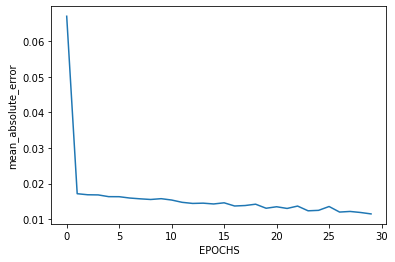

In [107]:
loss_per_epoch = model.history.history['mean_absolute_error']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel('EPOCHS')
plt.ylabel('mean_absolute_error')
plt.savefig('DATASET PREZZI DAILY mean absolute error (buono).png')

In [109]:
from datetime import datetime
a = [5,10,20,30]
minutes = []
for i in a:
    start_time = datetime.now()
    model.fit(X_20, y_20, epochs=i, batch_size=64)
    end_time = datetime.now()
    minutes.append(end_time - start_time)

Train on 3876 samples
Epoch 1/5
3876/3876 [==============================] - 8s 2ms/sample - loss: 2.6125e-04 - mean_absolute_error: 0.0116
Epoch 2/5
3876/3876 [==============================] - 7s 2ms/sample - loss: 2.8977e-04 - mean_absolute_error: 0.0124
Epoch 3/5
3876/3876 [==============================] - 7s 2ms/sample - loss: 2.3014e-04 - mean_absolute_error: 0.0109
Epoch 4/5
3876/3876 [==============================] - 7s 2ms/sample - loss: 2.1881e-04 - mean_absolute_error: 0.0106
Epoch 5/5
3876/3876 [==============================] - 8s 2ms/sample - loss: 1.9935e-04 - mean_absolute_error: 0.0101
Train on 3876 samples
Epoch 1/10
3876/3876 [==============================] - 7s 2ms/sample - loss: 2.0156e-04 - mean_absolute_error: 0.0102
Epoch 2/10
3876/3876 [==============================] - 7s 2ms/sample - loss: 1.9568e-04 - mean_absolute_error: 0.0101
Epoch 3/10
3876/3876 [==============================] - 8s 2ms/sample - loss: 2.0792e-04 - mean_absolute_error: 0.0104
Epoch 4/1

In [110]:
epochs = [5,10,20,30]

df_epoch = pd.DataFrame(data={'Epoch':epochs},index=minutes)
df_epoch

,Epoch
0 days 00:00:36.203514,5
0 days 00:01:30.952246,10
0 days 00:03:44.993311,20
0 days 00:03:55.994212,30


In [111]:
time_sec = []
for i in df_epoch.index:
    a = i.total_seconds()
    time_sec.append(a)

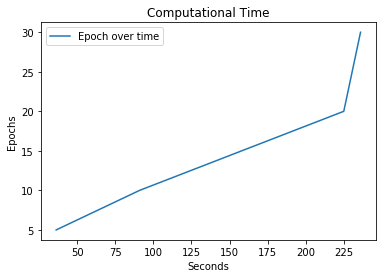

In [112]:
plt.plot(time_sec, epochs)
plt.xlabel('Seconds')
plt.ylabel('Epochs')
plt.title('Computational Time')
plt.legend(['Epoch over time'])
plt.savefig('DATASET PREZZI DAILY epochs vs time.png')

In [ ]:
## SCELGO 30 EPOCHS (non cambia molto in tempo tra 20 e 30)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_20.shape[1],1)))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mse', 
              optimizer='adam',
              metrics=['mean_absolute_error'])

In [13]:
model.fit(X_20, y_20, epochs=30, batch_size=64)

Train on 3876 samples
Epoch 1/30
3876/3876 [==============================] - 9s 2ms/sample - loss: 0.0221 - mean_absolute_error: 0.0821
Epoch 2/30
3876/3876 [==============================] - 6s 1ms/sample - loss: 5.9421e-04 - mean_absolute_error: 0.0177
Epoch 3/30
3876/3876 [==============================] - 6s 1ms/sample - loss: 5.6322e-04 - mean_absolute_error: 0.0173
Epoch 4/30
3876/3876 [==============================] - 6s 1ms/sample - loss: 5.5579e-04 - mean_absolute_error: 0.0172
Epoch 5/30
3876/3876 [==============================] - 6s 2ms/sample - loss: 5.6402e-04 - mean_absolute_error: 0.0173
Epoch 6/30
3876/3876 [==============================] - 6s 2ms/sample - loss: 5.3700e-04 - mean_absolute_error: 0.0169
Epoch 7/30
3876/3876 [==============================] - 7s 2ms/sample - loss: 5.2125e-04 - mean_absolute_error: 0.0167
Epoch 8/30
3876/3876 [==============================] - 7s 2ms/sample - loss: 5.3364e-04 - mean_absolute_error: 0.0168
Epoch 9/30
3876/3876 [========

In [15]:
dataset_total = pd.concat((df_train,df_test), axis=0)

In [16]:
inputs = dataset_total[len(dataset_total)-len(df_test)-WINDOWSIZE:].values

In [17]:
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [18]:
X_test = []
for i in range(WINDOWSIZE,len(inputs)):
    X_test.append(inputs[i-WINDOWSIZE:i, 0])

In [19]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(1670, 20, 1)

In [20]:
test_predictions20 = model.predict(X_test)
test_predictions20 = scaler.inverse_transform(test_predictions20)

/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


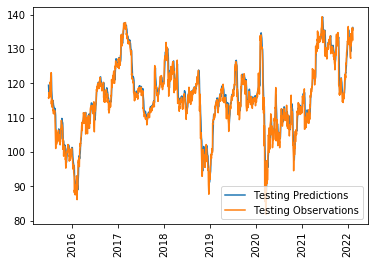

In [21]:
plt.plot(df_test.index, test_predictions20)
plt.plot(df_test.index, df_test.values)
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.savefig('Daily.png')

In [22]:
test_predictions20 = np.reshape(test_predictions20,(1670,))
te = df_test.values 
te = np.reshape(te,(1670,))

In [23]:
test_results20 = pd.DataFrame(data={'Test Predictions':test_predictions20, 'Actuals':te},index=df_test.index)
test_results20

,Test Predictions,Actuals
IBM DAILY DATA,,
2015-06-29,119.456261,115.847435
2015-06-30,118.628128,115.627098
2015-07-01,117.747597,116.927971
2015-07-02,117.314201,117.354454
2015-07-06,117.298592,117.098587
...,...,...
2022-02-07,135.996735,135.606552
2022-02-08,136.283859,135.389175
2022-02-09,136.291885,136.149994


In [25]:
from sklearn.metrics import r2_score
rmse20=np.sqrt(np.mean(((test_results20['Test Predictions']- test_results20['Actuals'])**2)))
mae20 = np.mean(np.abs(test_results20['Test Predictions']-test_results20['Actuals']))
MAPE20 = np.mean(np.abs(((test_results20['Test Predictions']-test_results20['Actuals'])/test_results20['Actuals'])*100))
r2_20 = r2_score(test_results20['Actuals'], test_results20['Test Predictions'])
rmse20, mae20, MAPE20, r2_20

(2.5071500733433605, 1.766966165325598, 1.5794639755435733, 0.9413745575698855)

In [39]:
prezzo = []
for i in test_results20['Actuals']:
    prezzo.append(i)

In [40]:
strategy_act=[]
i=1
while i < len(prezzo):
    if prezzo[i]>prezzo[i-1]:
        strategy_act.append(1)
    else:
        strategy_act.append(-1)
    i=i+1

In [41]:
prezzo_pre = []
for i in test_results20['Test Predictions']:
    prezzo_pre.append(i) 

In [42]:
strategy_pre=[]
i=1
while i < len(prezzo_pre):
    if prezzo_pre[i]>prezzo_pre[i-1]:
        strategy_pre.append(1)
    else:
        strategy_pre.append(-1)
    i=i+1

In [44]:
test_results20 = test_results20[1:]

In [45]:
test_results20['Strategy Pre'] = strategy_pre

/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
test_results20['Strategy Act'] = strategy_act

/Users/schisanoluca/opt/anaconda3/envs/Dataprediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
test_results20

,Test Predictions,Actuals,Strategy Pre,Strategy Act
IBM DAILY DATA,,,,
2015-06-30,118.628128,115.627098,-1,-1
2015-07-01,117.747597,116.927971,-1,1
2015-07-02,117.314201,117.354454,-1,1
2015-07-06,117.298592,117.098587,-1,-1
2015-07-07,117.458809,117.290474,1,1
...,...,...,...,...
2022-02-04,135.421875,135.517609,1,-1
2022-02-07,135.996735,135.606552,1,1
2022-02-08,136.283859,135.389175,1,-1


In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_results20['Strategy Act'], test_results20['Strategy Pre'])
cm

array([[362, 433],
       [419, 454]])

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(accuracy_score(test_results20['Strategy Act'], test_results20['Strategy Pre']))
print(precision_score(test_results20['Strategy Act'], test_results20['Strategy Pre']))
print(recall_score(test_results20['Strategy Act'], test_results20['Strategy Pre']))

0.4892086330935252
0.5118376550169109
0.5200458190148912
